In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.api import OLS
import statsmodels.api as sm

from scipy import stats

In [2]:
stock_fpath = r'C:\Users\The_Iron_Maiden\Documents\Python Scripts\Smarket.csv'

stock_data = pd.read_csv(stock_fpath)

For each date, we have recorded:

* the percentage returns for each of the five previous trading days, Lag1 through Lag5. 

We have also recorded: 
  
* Volume: the number of shares traded on the previous day, in billions
* Today: the percentage return on the date in question
* Direction: whether the market was Up or Down on this date

In [3]:
stock_data.head(2)

,Unnamed: 0,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up


In [4]:
stock_data.rename(columns={'Unnamed: 0':'index'}, 
                 inplace=True)
stock_data.set_index('index')

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
index,,,,,,,,,
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1246,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1247,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1248,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up


In [5]:
stock_data.describe()

,index,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,625.500000,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,360.988227,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,1.000000,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,313.250000,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,625.500000,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,937.750000,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,1250.000000,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


Thecor()function produces a matrix that contains all of the pairwisecorrelations among the predictors in a data set. 

In [6]:
stock_data.corr()

,index,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
index,1.000000,0.979773,0.035415,0.036022,0.038989,0.041437,0.035025,0.546348,0.035273
Year,0.979773,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.035415,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.036022,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.038989,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.041437,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.035025,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.546348,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.035273,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


## Next, we will fit a logistic regression model in order to predict Direction using Lag1 through Lag5 and Volume.

___First we need to binarize the outcome variable___ using pandas.get_dummies, which creates new columns that encodes columns with string categories to binary columns for each level

In [7]:
#https://stackoverflow.com/questions/38704545/how-to-binarize-the-values-in-a-pandas-dataframe

labels = ['Down', 'Up']

stock_data = pd.get_dummies(stock_data)
stock_data.head(3)

,index,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction_Down,Direction_Up
0,1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,0,1
1,2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,0,1
2,3,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,1,0


In [8]:
# prep data input
log_y = stock_data['Direction_Up']
log_X = stock_data[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]
log_X = sm.add_constant(log_X) # need the constant to add an intercept!!!
num_samples = log_X.shape[0]

___Suggestion: show results without constant added___

In [9]:
logit = sm.Logit(log_y, log_X)

fit_logit_model = logit.fit()

fit_logit_model.summary()

Optimization terminated successfully.
         Current function value: 2.197001
         Iterations 4


d:\users\the_iron_maiden\anaconda3\envs\nape_training\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\users\the_iron_maiden\anaconda3\envs\nape_training\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\users\the_iron_maiden\anaconda3\envs\nape_training\lib\site-packages\statsmodels\discrete\discrete_model.py:3409: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Direction_Up   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Wed, 13 May 2020   Pseudo R-squ.:                     inf
Time:                        21:33:29   Log-Likelihood:                -2746.3
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.050     -1.457      0.145      -0.171       0.025
Lag2          -0.0423      0.050     -0.845      0.398      -0.140       0.056
Lag3           0.0111      0.050      0.222      0.824      -0.087       0.109
Lag4           0.0094      0.050      0.187      0.851      -0.089       0.107
Lag5           0.0103      0.050      0.208      0.835      -0.087       0.107
Volume         0.1354      0.158      0.855      0.392      -0.175       0.446
==============================================================================
"""

___Negative lag1 means if market was up the previous day, there's a lower likelihood the market will be up the current day.___

___Conversely if the number of shares traded (volume) was high the previous day, there's a higher liklihood the market will be up the current day___

In [10]:
# grab the coefficients
fit_logit_model.params

# note: generally methods of an object 
# https://stackoverflow.com/questions/32129064/what-are-the-parentheses-for-at-the-end-of-python-method-names

const    -0.126000
Lag1     -0.073074
Lag2     -0.042301
Lag3      0.011085
Lag4      0.009359
Lag5      0.010313
Volume    0.135441
dtype: float64

___With the fitted model, we can look at the ouput probabilities for the sample data___

note:
* you need to call the predict on the fitted model (`logit.fit()`) (not the base model with data loaded in - `logit` in this case)

In [11]:
logit_dict = {}

In [12]:
logit_dict['ypred'] = fit_logit_model.predict(log_X)

In [13]:
logit_dict['ypred'][:5]

0    0.507084
1    0.481468
2    0.481139
3    0.515222
4    0.510781
dtype: float64

In [14]:
logit_thresh = 0.5

# had to use a dataframe/series for the 2 lines below; list wouldn't work with logical indexing based on series
# list would be fine if logical indexing result were a boolean list, I believe
logit_dict['ypred_categ'] = pd.DataFrame(['Down']*num_samples, columns=['category']) 
logit_dict['ypred_categ'][logit_dict['ypred'] > logit_thresh] = 'Up'

# change up/down to 0/1 to make confusion matrix
logit_dict['ypred_binary'] = pd.DataFrame([0]*num_samples, columns=['binary_category']) 
logit_dict['ypred_binary'][logit_dict['ypred'] > logit_thresh] = 1

In [15]:
logit_dict['ypred_categ'].head(5)

,category
0,Up
1,Down
2,Down
3,Up
4,Up


___Make a confusion matrix___

sklearn metrics.confusion_matrix simply calculates TP, TN, FP, FN and outputs a square matrix; can be plotted as heatmap

In [16]:
def confused_matrix(actual_y, predict_y, labels):
    
    confusion_mat = metrics.confusion_matrix(actual_y, predict_y, labels=[0, 1])

    ax= plt.subplot()
    # fmt changes how numbers are shown
    sns.heatmap(confusion_mat, annot=True, ax = ax, 
                fmt='g', cmap = 'Greens', cbar_kws={'label': 'Count'}); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    # some formatting: set x ticks and label to top of plot for ease of reading
    ax.xaxis.set_ticklabels(labels); ax.xaxis.tick_top(); ax.xaxis.set_label_position('top')
    ax.yaxis.set_ticklabels(labels);
    
    return confusion_mat

___Note: R's table() switches the x and y axis, so the FP and FN are switched in locations from sklearn's confusion matrix___

TN, FP  
FN, TP

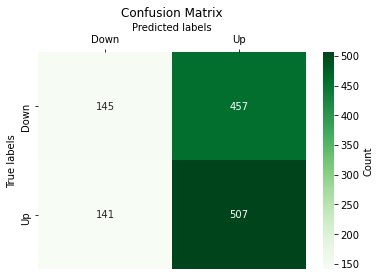

In [17]:
cm = confused_matrix(log_y, logit_dict['ypred_binary'], labels)

In [18]:
logit_accuracy = ( cm[0,0]+cm[1,1] ) / num_samples
'{}% accuracy'.format(logit_accuracy * 100)

'52.16% accuracy'

Lots of false positives (market didn't actually go up). These are bad - you lost money if you bought stocks.

Also accuracy is misleading since we predicted using the same data as we trained the model on. Accuracy here is overestimated since the model is biased towards the test data.

### We need to split the original data into a training and test set

In [19]:
logit_dict_2005 = {}

In [20]:
X_train_2005 = log_X[stock_data['Year'] < 2005]
y_train_2005 = log_y[stock_data['Year'] < 2005]

X_test_2005 = log_X[stock_data['Year'] >= 2005] 
y_test_2005 = log_y[stock_data['Year'] >= 2005]

logit_dict_2005['num_samples_train'] = X_train_2005.shape[0]
logit_dict_2005['num_samples_test'] = X_test_2005.shape[0]

print('{} training samples; {} test samples'.format(logit_dict_2005['num_samples_train'], 
                                                    logit_dict_2005['num_samples_test']))

998 training samples; 252 test samples


In [21]:
# can also easily split with sklearn
X_train, X_test, y_train, y_test = train_test_split(log_X, log_y, test_size=0.33, random_state=42)

In [22]:
# fit and predict the training/test data
fit_logit_2005 = sm.Logit(y_train_2005, X_train_2005).fit()
logit_dict_2005['ypred_test'] = fit_logit_2005.predict_prob(X_test_2005)


Optimization terminated successfully.
         Current function value: 3.346650
         Iterations 4


Because logistic regression outputs a probability between 0 and 1, I made a function that converts those values into categories

In [23]:
# turn probabilities to categories using threshold
# similar to lines of code above, but adapted to accomodate subsampling of original data
def categorize_prob(ypred, thresh, labels):
    
    num_samps = ypred.shape[0]
    
    ypred_category = pd.DataFrame([labels[0]]*num_samps, columns=['category']) 
    ### these two lines are needed to match the indices of the category df and the probabilities df
    ypred_category['index'] = ypred.index
    ypred_category = ypred_category.set_index('index')
    ###
    ypred_category[ypred > thresh] = labels[1]
    
    return ypred_category


logit_thresh = 0.5
logit_dict_2005['ypred_categ'] = categorize_prob(logit_dict_2005['ypred_test'], logit_thresh, labels)

logit_dict_2005['ypred_binary'] = categorize_prob(logit_dict_2005['ypred_test'], logit_thresh, [0, 1])

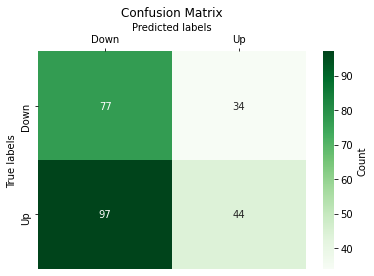

In [24]:
labels = ['Down', 'Up']

cm = confused_matrix(y_test_2005, logit_dict_2005['ypred_binary'], labels)

In [25]:
logit_accuracy = ( cm[0,0]+cm[1,1] ) / logit_dict_2005['num_samples_test']
'{}% accuracy'.format(logit_accuracy * 100)

'48.01587301587302% accuracy'

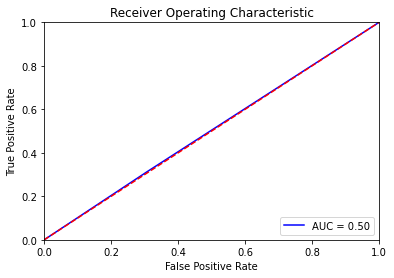

In [26]:
def plot_ROC(y_actual, y_pred):
    fpr, tpr, threshold = metrics.roc_curve(y_actual, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

plot_ROC(y_test_2005, logit_dict_2005['ypred_binary'])

# LDA

___Couldn't find LDA for statsmodel!!!___

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [28]:
lda_dict = {}

___SKlearn wants (X,y) input, not (y,X) as statsmodel wants it...___

In [29]:
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
X = X_train_2005[['Lag1', 'Lag2']]
y = y_train_2005
fitted_lda = lda.fit(X, y)

X_test = X_test_2005[['Lag1', 'Lag2']]
lda_dict['ypred_test'] = fitted_lda.predict(X_test)

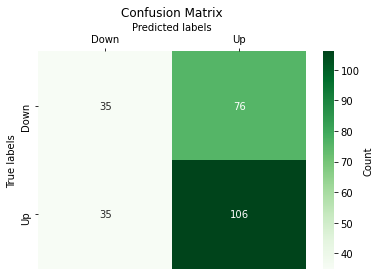

In [30]:
cm = confused_matrix(y_test_2005, lda_dict['ypred_test'], labels)

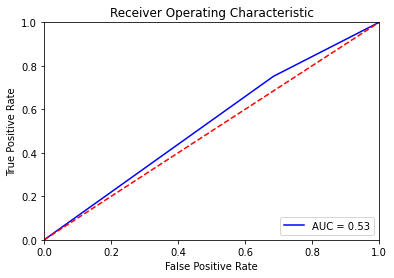

In [31]:
plot_ROC(y_test_2005, lda_dict['ypred_test'])

In [32]:
logit_accuracy = ( cm[0,0]+cm[1,1] ) / X_test.shape[0]
'{}% accuracy'.format(logit_accuracy * 100)

'55.952380952380956% accuracy'

# QDA

In [33]:
qda_dict = {}

In [34]:
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
X = X_train_2005[['Lag1', 'Lag2']]
y = y_train_2005
fitted_qda = qda.fit(X, y)

qda_dict['ypred_test'] = fitted_qda.predict(X_test_2005[['Lag1', 'Lag2']])

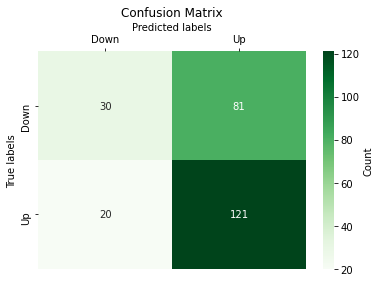

In [35]:
cm = confused_matrix(y_test_2005, qda_dict['ypred_test'], labels)

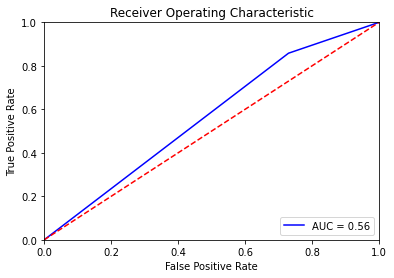

In [36]:
plot_ROC(y_test_2005, qda_dict['ypred_test'])

In [37]:
qda_accuracy = ( cm[0,0]+cm[1,1] ) / X_test_2005.shape[0]
'{}% accuracy'.format(qda_accuracy * 100)

'59.92063492063492% accuracy'

In [38]:
print(fitted_qda.means_)
print('')
print(fitted_qda.covariance_)
print('')
print(fitted_qda.priors_)

[[ 0.04279022  0.03389409]
 [-0.03954635 -0.03132544]]

[array([[ 1.50662277, -0.03924806],
       [-0.03924806,  1.53559498]]), array([[ 1.51700576, -0.02787349],
       [-0.02787349,  1.49026815]])]

[0.49198397 0.50801603]


___Mean is a 2x2 matrix with dimensions as class and variable___

___Covariance is a 2 item list (for each class). Each item is a 2x2 array containing covariance between the two variables.___

# KNN

In [39]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn_dict = {}

In [40]:
X = X_train_2005[['Lag1', 'Lag2']]
y = y_train_2005
fitted_knn = knn.fit(X, y)

knn_dict['ypred_test'] = fitted_knn.predict(X_test_2005[['Lag1', 'Lag2']])

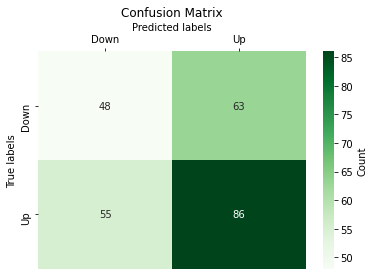

In [41]:
cm = confused_matrix(y_test_2005, knn_dict['ypred_test'], labels)

In [42]:
knn_accuracy = ( cm[0,0]+cm[1,1] ) / X_test_2005.shape[0]
'{}% accuracy'.format(knn_accuracy * 100)

'53.17460317460318% accuracy'

## Bonus: plot data and boundaries for LDA and QDA

In [43]:
from matplotlib import colors
# Colormap
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)

In [48]:
# https://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html

# Plot functions
def plot_data_(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(2, 2, fig_index)
    if fig_index == 1:
        plt.title('Linear Discriminant Analysis')
        plt.xlabel('Lag 1')
        plt.ylabel('Lag 2')
    elif fig_index == 2:
        plt.title('Quadratic Discriminant Analysis')
        plt.xlabel('Lag 1')
        plt.ylabel('Lag 2')
    elif fig_index == 3:
        plt.ylabel('Data with\n varying covariances')

    tp = (y == y_pred)  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                s=20, color='#990000')  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
    plt.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                s=20, color='#000099')  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=colors.Normalize(0., 1.), zorder=0)
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             '*', color='yellow', markersize=15, markeredgecolor='grey')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             '*', color='yellow', markersize=15, markeredgecolor='grey')

    return splot

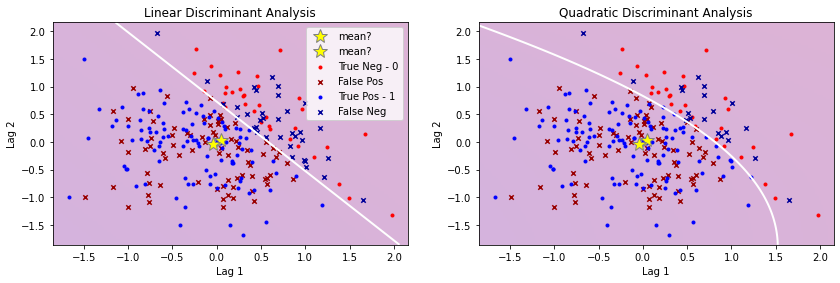

In [49]:
plt.figure(figsize=(14,9))
fig_index = 1
splot = plot_data_(lda, X_test_2005[['Lag1', 'Lag2']].values, y_test_2005, lda_dict['ypred_test'], fig_index)
splot.legend(['mean?', 'mean?','True Neg - 0', 'False Pos', 'True Pos - 1', 'False Neg'])

fig_index = 2
splot2 = plot_data_(qda, X_test.values, y_test_2005, qda_dict['ypred_test'], fig_index)
